In [8]:
import Utils
import copy
import torch
import warnings
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision

### Check Image Classification Data Count

In [2]:
from torch.utils.data import Dataset

# Classification With mask
class classification_mask_dataset(Dataset):
    def __init__(self, classification_dir, segmentation_dir, txt_COVID, txt_NonCOVID, transform=None, lateral_map=1,
                 min_seg=0.01):
        self.classification_dir = classification_dir
        self.segmentation_dir = segmentation_dir

        self.txt_path = [txt_COVID, txt_NonCOVID]
        self.classes = ['CT_COVID', 'CT_NonCOVID']
        self.num_cls = len(self.classes)

        self.img_list = []
        self.segment_list = []
        self.min_seg = min_seg

        for c in range(self.num_cls):
            # Classification List
            cls_list = [[os.path.join(self.classification_dir, self.classes[c], item), c] for item in
                        read_txt(self.txt_path[c])]
            self.img_list += cls_list
            # Segmentation List
            seg_list = [[os.path.join(self.segmentation_dir, self.classes[c], "lateral_map" + str(lateral_map),
                                      item.replace('.jpg', '.png')), c] for item in read_txt(self.txt_path[c])]
            self.segment_list += seg_list

        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Original Data
        img_path = self.img_list[idx][0]
        image = Image.open(img_path).convert('RGB')
        image = image.resize((256, 256))

        # Segmentation Data
        seg_path = self.segment_list[idx][0]
        seg = Image.open(seg_path).convert('RGB')
        seg = seg.rotate(-90, expand=True)
        seg = seg.resize((256, 256))

        # Mask with Original Data
        # Step 1 => Segmentation Min-Max Normalization + Min Value(Hyperparameter)
        seg_np = np.array(seg)
        seg_mask = (seg_np - seg_np.min()) / (seg_np.max() - seg_np.min()) + self.min_seg
        # Clip max = 1
        seg_mask = np.clip(seg_mask, 0, 1)

        # Step 2 => Original Data with seg_mask
        image_with_mask = np.multiply(image, seg_mask)

        # Step 3 => Change Numpy Dtype => For Using Image Preprocessing
        image_with_mask = Image.fromarray(np.uint8(image_with_mask))

        if self.transform:
            image_with_mask = self.transform(image_with_mask)
            # image = self.transform(image)

        sample = {'img': image_with_mask,
                  'label': int(self.img_list[idx][1])}
        return sample

In [16]:
import os

def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data

In [53]:
len(os.listdir(os.path.join(audio_dir, audio_classes[0])))

136

In [274]:
from PIL import Image

class multi_modal_dataset(Dataset):
    def __init__(self, classification_dir, segmentation_dir, txt_COVID, txt_NonCOVID,
                 audio_dir, select_num,
                 lateral_map=1, min_seg=0.01, transform=None):
        
        # Dataset Root Directory
        self.classification_dir = classification_dir
        self.segmentation_dir = segmentation_dir
        self.audio_dir = audio_dir
        
        # Subject
        self.txt_path = [txt_COVID, txt_NonCOVID]
        self.classes = ['CT_COVID', 'CT_NonCOVID']
        self.audio_classes = ['pos', 'neg']
        self.num_cls = len(self.classes)

        self.img_list = []
        self.segment_list = []
        self.audio_list = []
        
        self.min_seg = min_seg
        self.select_num = select_num
        
        for c in range(self.num_cls):
            # Classification List
            cls_list = [[os.path.join(self.classification_dir, self.classes[c], item), c] for item in
                        read_txt(self.txt_path[c])]
            self.img_list += cls_list
            
            # Audio List
            a_list = [[os.path.join(audio_dir, audio_classes[c], item), c] for item in os.listdir(os.path.join(audio_dir, audio_classes[c]))]
            self.audio_list += a_list
            
        # Split Image COVID & Non-COVID
        self.img_list = np.array(self.img_list)
        pos_index = (self.img_list[:,1]=='0')
        neg_index = (self.img_list[:,1]=='1')
        pos_img_list = self.img_list[:, 0][pos_index]
        neg_img_list = self.img_list[:, 0][neg_index]

        # Select Image List
        select_pos_img_list = np.random.choice(pos_img_list, self.select_num)
        select_neg_img_list = np.random.choice(neg_img_list, self.select_num)

        # Mapping Segment List
        select_pos_seg_list = []
        select_neg_seg_list = []
        for s_p_i_l in select_pos_img_list:
            select_pos_seg_list.append(os.path.join(segmentation_dir, s_p_i_l.split('/')[-2], "lateral_map" + str(lateral_map),
                              s_p_i_l.split('/')[-1].replace('.jpg', '.png')))
        for s_n_i_l in select_neg_img_list:
            select_neg_seg_list.append(os.path.join(segmentation_dir, s_n_i_l.split('/')[-2], "lateral_map" + str(lateral_map),
                              s_n_i_l.split('/')[-1].replace('.jpg', '.png')))

        # Split Audio COIVD & Non-COVID
        self.audio_list = np.array(self.audio_list)
        pos_index = (self.audio_list[:,1]=='0')
        neg_index = (self.audio_list[:,1]=='1')
        pos_audio_list = self.audio_list[:, 0][pos_index]
        neg_audio_list = self.audio_list[:, 0][neg_index]

        # Select Audio List
        select_pos_audio_list = np.random.choice(pos_audio_list, select_num)
        select_neg_audio_list = np.random.choice(neg_audio_list, select_num)
        
        # Make DICT
        self.data_list = []
        for i in range(num_cls):
            for j in range(self.select_num):
                if i == 0:
                    data_dict = {'img': select_pos_img_list[j],
                                 'seg': select_pos_seg_list[j],
                                 'audio': select_pos_audio_list[j],
                                 'label': i}
                else:
                    data_dict = {'img': select_neg_img_list[j],
                                 'seg': select_neg_seg_list[j],
                                 'audio': select_neg_audio_list[j],
                                 'label': i}
                self.data_list.append(data_dict)

        self.transform = transform

    def __len__(self):
        return len(self.select_num*2)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Original Data
        img_path = self.data_list[idx]['img']
        image = Image.open(img_path).convert('RGB')
        image = image.resize((256, 256))

        # Segmentation Data
        seg_path = self.data_list[idx]['seg']
        seg = Image.open(seg_path).convert('RGB')
        seg = seg.rotate(-90, expand=True)
        seg = seg.resize((256, 256))
        
        # Audio Data
        audio_path = self.data_list[idx]['audio']
        audio = Image.open(audio_path).convert('RGB')

        # Mask with Original Data
        # Step 1 => Segmentation Min-Max Normalization + Min Value(Hyperparameter)
        seg_np = np.array(seg)
        seg_mask = (seg_np - seg_np.min()) / (seg_np.max() - seg_np.min()) + self.min_seg
        # Clip max = 1
        seg_mask = np.clip(seg_mask, 0, 1)

        # Step 2 => Original Data with seg_mask
        image_with_mask = np.multiply(image, seg_mask)

        # Step 3 => Change Numpy Dtype => For Using Image Preprocessing
        image_with_mask = Image.fromarray(np.uint8(image_with_mask))
        
        if self.transform:
            image_with_mask = self.transform(image_with_mask)
            audio = self.transform(audio)
        
        
        sample = {'img': image_with_mask,
                  'audio': audio,
                  'label': int(self.data_list[idx]['label'])}
        return sample

In [275]:
# Normalization
normalize = transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])
trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

In [276]:
trainset = multi_modal_dataset(classification_dir='./dataset/image/classfication/',
                               segmentation_dir='./dataset/image/classfication/Segmentation/',
                               txt_COVID='./dataset/image/classfication/Data-split/COVID/trainCT_COVID.txt',
                               txt_NonCOVID='./dataset/image/classfication/Data-split/NonCOVID/trainCT_NonCOVID.txt',
                               audio_dir = './dataset/audio/preprocess/train/',
                               select_num=500,
                               lateral_map=3, min_seg=0.8,
                               transform=trans)

In [238]:
from matplotlib import pyplot as plt

In [304]:
count = 0
for s in trainset:
    if s['label'] == 1:
        break

In [278]:
original_train_set = torchvision.datasets.ImageFolder(root='./dataset/audio/spectrum/train', transform=trans)

In [279]:
for o_s in original_train_set:
    break

In [296]:
torch.equal(s['audio'], o_s[0])

False

In [305]:
s['audio'][0, 100:110, 100:110]

tensor([[ 0.1254, -1.6727, -2.0837, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179,
         -2.1179, -2.1179],
        [-0.1486, -1.8953, -2.1008, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179,
         -2.1008, -2.1008],
        [-0.6452, -2.0494, -2.1179, -2.1179, -2.1179, -2.1179, -2.1008, -2.0837,
         -2.0665, -2.0665],
        [-0.9705, -2.0837, -2.1179, -2.1179, -2.1179, -2.1179, -2.1008, -2.0494,
         -2.0323, -2.0665],
        [-0.8507, -2.1008, -2.1179, -2.1179, -2.1179, -2.1179, -2.0665, -1.9980,
         -2.0323, -2.0665],
        [-0.8507, -2.0837, -2.1179, -2.1179, -2.1179, -2.1179, -2.0837, -2.0494,
         -2.0665, -2.0837],
        [-1.2274, -2.1008, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179, -2.1008,
         -2.1008, -2.1179],
        [-1.4500, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179,
         -2.1179, -2.1179],
        [-1.4329, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179, -2.1179,
         -2.1179, -2.1179],
        [-1.2788, -

In [306]:
o_s[0][0, 100:110, 100:110]

tensor([[-2.1008, -0.4397,  0.9988,  1.5639,  1.6324,  1.1187, -0.0287, -0.6794,
         -1.1247, -1.2445],
        [-2.1179, -0.3198,  1.1529,  1.6838,  1.7180,  1.1358, -0.0116, -0.6452,
         -1.0219, -1.2274],
        [-2.0494, -0.1999,  1.3070,  1.8208,  1.8550,  1.2385,  0.1426, -0.4568,
         -0.7650, -1.1589],
        [-1.9980, -0.1657,  1.3584,  1.8893,  1.9235,  1.3242,  0.2796, -0.2856,
         -0.5767, -1.0904],
        [-2.0323, -0.1486,  1.4612,  2.0092,  2.0263,  1.4269,  0.4337, -0.0972,
         -0.5596, -0.9877],
        [-2.0837, -0.0287,  1.5468,  2.0092,  1.9920,  1.2557,  0.1939, -0.3369,
         -0.8335, -1.1589],
        [-2.0837, -0.0629,  1.4269,  1.7865,  1.7352,  1.0331,  0.0227, -0.4911,
         -0.9020, -1.3644],
        [-2.0837, -0.1314,  1.3070,  1.6667,  1.5982,  0.9646,  0.0056, -0.4911,
         -0.8678, -1.4500],
        [-2.0837, -0.3198,  1.2214,  1.7865,  1.8379,  1.2899,  0.2624, -0.3027,
         -0.7650, -1.4500],
        [-1.8782, -

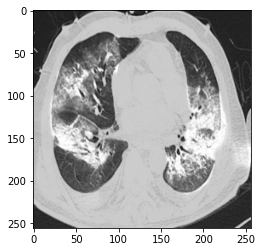

In [265]:
plt.imshow(s['img'])

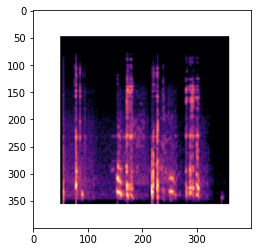

In [266]:
plt.imshow(s['audio'])

In [267]:
s['label']

0

In [249]:
pos_count = 0
neg_count = 0

for s in trainset:
    if s['label'] == 0:
        pos_count+=1
    else:
        neg_count+=1

In [250]:
print('Num of COVID: ', pos_count)
print('Num of Non-COVID: ', neg_count)

Num of COVID:  500
Num of Non-COVID:  500


In [228]:
s['img'].shape

torch.Size([3, 224, 224])

In [237]:
s['audio']

tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         ...,
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

        [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         ...,
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

        [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
         [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
         [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.

In [220]:
s

(<PIL.Image.Image image mode=RGB size=400x400 at 0x7F4602278850>, 0)

In [213]:
data_list[0]

{'img': './dataset/image/classfication/CT_COVID/2020.02.22.20024927-p19-68%4.png',
 'seg': './dataset/image/classfication/Segmentation/CT_COVID/lateral_map3/2020.02.22.20024927-p19-68%4.png',
 'audio': './dataset/audio/preprocess/train/pos/cough-heavyY635Ri3QFMcOKC0ckXgW2r0xJ422.png',
 'label': 0}

In [196]:
classification_dir = './dataset/image/classfication/'
segmentation_dir = './dataset/image/classfication/Segmentation/'
audio_dir = './dataset/audio/preprocess/train/'

txt_path = ['./dataset/image/classfication/Data-split/COVID/trainCT_COVID.txt', 
                 './dataset/image/classfication/Data-split/NonCOVID/trainCT_NonCOVID.txt']

select_num = 200

classes = ['CT_COVID', 'CT_NonCOVID']
audio_classes = ['pos', 'neg']
num_cls = len(classes)

img_list = []
segment_list = []
audio_list = []

for c in range(num_cls):
    # Classification List
    cls_list = [[os.path.join(classification_dir, classes[c], item), c] for item in read_txt(txt_path[c])]
    img_list += cls_list
    # Segmentation List
    seg_list = [[os.path.join(segmentation_dir, classes[c], "lateral_map" + str(3),
                              item.replace('.jpg', '.png')), c] for item in read_txt(txt_path[c])]
    segment_list += seg_list
    # Audio List
    a_list = [[os.path.join(audio_dir, audio_classes[c], item), c] for item in os.listdir(os.path.join(audio_dir, audio_classes[c]))]
    audio_list += a_list

# Split Image COVID & Non-COVID
img_list = np.array(img_list)
pos_index = (img_list[:,1]=='0')
neg_index = (img_list[:,1]=='1')
pos_img_list = img_list[:, 0][pos_index]
neg_img_list = img_list[:, 0][neg_index]

# Select Image List
select_pos_img_list = np.random.choice(pos_img_list, select_num)
select_neg_img_list = np.random.choice(neg_img_list, select_num)

# Mapping Segment List
select_pos_seg_list = []
select_neg_seg_list = []
for s_p_i_l in select_pos_img_list:
    select_pos_seg_list.append(os.path.join(segmentation_dir, s_p_i_l.split('/')[-2], "lateral_map" + str(3),
                              s_p_i_l.split('/')[-1].replace('.jpg', '.png')))
for s_n_i_l in select_neg_img_list:
    select_neg_seg_list.append(os.path.join(segmentation_dir, s_n_i_l.split('/')[-2], "lateral_map" + str(3),
                              s_n_i_l.split('/')[-1].replace('.jpg', '.png')))

# Split Audio COIVD & Non-COVID
audio_list = np.array(audio_list)
pos_index = (audio_list[:,1]=='0')
neg_index = (audio_list[:,1]=='1')
pos_audio_list = audio_list[:, 0][pos_index]
neg_audio_list = audio_list[:, 0][neg_index]

# Select Audio List
select_pos_audio_list = np.random.choice(pos_audio_list, select_num)
select_neg_audio_list = np.random.choice(neg_audio_list, select_num)

In [203]:
data_list = []

In [201]:
num_cls

2

In [202]:
for i in range(num_cls):
    print(i)

0
1


In [204]:
for i in range(num_cls):
    for j in range(select_num):
        if i == 0:
            data_dict = {'img': select_pos_img_list[j], 
                         'seg': select_pos_seg_list[j], 
                         'audio': select_pos_audio_list[j], 
                         'label': i}
        else:
            data_dict = {'img': select_neg_img_list[j], 
                         'seg': select_neg_seg_list[j], 
                         'audio': select_neg_audio_list[j], 
                         'label': i}
        data_list.append(data_dict)

In [205]:
data_list[0]

{'img': './dataset/image/classfication/CT_COVID/2020.02.22.20024927-p19-68%4.png',
 'seg': './dataset/image/classfication/Segmentation/CT_COVID/lateral_map3/2020.02.22.20024927-p19-68%4.png',
 'audio': './dataset/audio/preprocess/train/pos/cough-heavyY635Ri3QFMcOKC0ckXgW2r0xJ422.png',
 'label': 0}

In [199]:
len(select_pos_audio_list)

200

In [194]:
audio_list

array([['cough-heavys1x2Ze9iVZNf6oFZDAZ4S9x3Cky2.png', '0'],
       ['cough-shallowy0TkG5sfyhadW3VSct50RTl3HN02.png', '0'],
       ['cough-shallowffyNrzu5ZGXrZ0I7MbxBwqbtIln1.png', '0'],
       ...,
       ['cough-shallowBHFxu6LIoWfHOaN9fXmkO5xBXyz2.png', '1'],
       ['cough-heavyfKZtrxD1qFVpLIgnmwEzWvnQZc83.png', '1'],
       ['cough-shallowCDJLmx0CWdNRiAvgFwn2aHonth43.png', '1']],
      dtype='<U45')

In [193]:
select_pos_audio_list

array(['cough-shallow6T43bddKoKfG7MwnJWvrPZSsyrc2.png',
       'cough-shallow2vH4QMrMaMMm5oZYScY0b36Z8MC3.png',
       'cough-heavyZzKpUtFGzsVEK7E1wsVGRftKdx93.png',
       'cough-shallowcf4RgKotFbYPn2HsLdxHyiChY3I2.png',
       'cough-shallowptuwF1pj4ibIoVuZmt4nKb5naiZ2.png',
       'cough-shallowiS29Ewab4XQHypUcZLygL7AYH6J2.png',
       'cough-shallowFi2lLmV3LHR5brvXs0z1JSKDvnI2.png',
       'cough-heavykB7J1mRmiPbjIVTAgovzFwP5nQm1.png',
       'cough-shallowUhYCvhOCn2erbzJc5faN4ek3D1I2.png',
       'cough-shallowiYM9uJMyO1UoXTo1tc7rXvsI4bm1.png',
       'cough-shallow3CwioNQVDBQ6CttLyFVRJpMpVHk2.png',
       'cough-shallowdvRr97gwv7Y34YqaccErnWcYRY53.png',
       'cough-shallowHYGtUoMDukOlfkkQ7rgRPhuKorA3.png',
       'cough-heavyxRTpzeZwMiQaC5YCnlXZeDwgcvL2.png',
       'cough-shallowHYGtUoMDukOlfkkQ7rgRPhuKorA3.png',
       'cough-shallowxRTpzeZwMiQaC5YCnlXZeDwgcvL2.png',
       'cough-shallowOSva8KJZQuZDquBrWQRFdEOtKFc2.png',
       'cough-heavygpcoorcyfuXQZxcUFTxthUKOua03.png',


In [171]:
pos_segment_list

array(['./dataset/image/classfication/Segmentation/CT_COVID/lateral_map3/2020.01.24.919183-p27-132.png',
       './dataset/image/classfication/Segmentation/CT_COVID/lateral_map3/2020.01.24.919183-p27-133.png',
       './dataset/image/classfication/Segmentation/CT_COVID/lateral_map3/2020.01.24.919183-p27-134.png',
       './dataset/image/classfication/Segmentation/CT_COVID/lateral_map3/2020.01.24.919183-p27-135.png',
       './dataset/image/classfication/Segmentation/CT_COVID/lateral_map3/2020.02.10.20021584-p6-52%0.png',
       './dataset/image/classfication/Segmentation/CT_COVID/lateral_map3/2020.02.10.20021584-p6-52%1.png',
       './dataset/image/classfication/Segmentation/CT_COVID/lateral_map3/2020.02.10.20021584-p6-52%10.png',
       './dataset/image/classfication/Segmentation/CT_COVID/lateral_map3/2020.02.10.20021584-p6-52%11.png',
       './dataset/image/classfication/Segmentation/CT_COVID/lateral_map3/2020.02.10.20021584-p6-52%12.png',
       './dataset/image/classfication/Segm

In [172]:
select_pos_img_list = np.random.choice(pos_img_list, 200)

In [189]:
select_pos_seg_list = []

for s_p_i_l in select_pos_img_list:
    select_pos_seg_list.append(os.path.join(segmentation_dir, s_p_i_l.split('/')[-2], "lateral_map" + str(3),
                              s_p_i_l.split('/')[-1].replace('.jpg', '.png')))

In [191]:
select_pos_img_list

array(['./dataset/image/classfication/CT_COVID/2020.03.11.20033159-p12-45%5.png',
       './dataset/image/classfication/CT_COVID/2020.02.25.20021568-p23-108%13.png',
       './dataset/image/classfication/CT_COVID/2020.02.23.20026856-p17-115%2.png',
       './dataset/image/classfication/CT_COVID/2020.02.25.20021568-p23-108%15.png',
       './dataset/image/classfication/CT_COVID/2020.02.23.20026856-p17-115%1.png',
       './dataset/image/classfication/CT_COVID/2020.02.25.20021568-p23-108%14.png',
       './dataset/image/classfication/CT_COVID/2020.02.10.20021584-p6-52%10.png',
       './dataset/image/classfication/CT_COVID/2020.02.26.20027938-p6-80_1%1.png',
       './dataset/image/classfication/CT_COVID/2020.03.04.20031047-p12-81%3.png',
       './dataset/image/classfication/CT_COVID/2020.02.26.20026989-p34-114_2%1.png',
       './dataset/image/classfication/CT_COVID/2020.03.04.20031047-p12-81%1.png',
       './dataset/image/classfication/CT_COVID/2020.02.24.20027052-p8-73%1.png',
     

In [190]:
select_pos_seg_list

['./dataset/image/classfication/Segmentation/CT_COVID/lateral_map3/2020.03.11.20033159-p12-45%5.png',
 './dataset/image/classfication/Segmentation/CT_COVID/lateral_map3/2020.02.25.20021568-p23-108%13.png',
 './dataset/image/classfication/Segmentation/CT_COVID/lateral_map3/2020.02.23.20026856-p17-115%2.png',
 './dataset/image/classfication/Segmentation/CT_COVID/lateral_map3/2020.02.25.20021568-p23-108%15.png',
 './dataset/image/classfication/Segmentation/CT_COVID/lateral_map3/2020.02.23.20026856-p17-115%1.png',
 './dataset/image/classfication/Segmentation/CT_COVID/lateral_map3/2020.02.25.20021568-p23-108%14.png',
 './dataset/image/classfication/Segmentation/CT_COVID/lateral_map3/2020.02.10.20021584-p6-52%10.png',
 './dataset/image/classfication/Segmentation/CT_COVID/lateral_map3/2020.02.26.20027938-p6-80_1%1.png',
 './dataset/image/classfication/Segmentation/CT_COVID/lateral_map3/2020.03.04.20031047-p12-81%3.png',
 './dataset/image/classfication/Segmentation/CT_COVID/lateral_map3/2020.0

In [186]:
s_p_i_l

NameError: name 's_p_i_l' is not defined

In [178]:
select_pos_img_list[0].split('/')

['.',
 'dataset',
 'image',
 'classfication',
 'CT_COVID',
 '2020.03.11.20033159-p12-45%5.png']

In [179]:
select_pos_img_list

array(['./dataset/image/classfication/CT_COVID/2020.03.11.20033159-p12-45%5.png',
       './dataset/image/classfication/CT_COVID/2020.02.25.20021568-p23-108%13.png',
       './dataset/image/classfication/CT_COVID/2020.02.23.20026856-p17-115%2.png',
       './dataset/image/classfication/CT_COVID/2020.02.25.20021568-p23-108%15.png',
       './dataset/image/classfication/CT_COVID/2020.02.23.20026856-p17-115%1.png',
       './dataset/image/classfication/CT_COVID/2020.02.25.20021568-p23-108%14.png',
       './dataset/image/classfication/CT_COVID/2020.02.10.20021584-p6-52%10.png',
       './dataset/image/classfication/CT_COVID/2020.02.26.20027938-p6-80_1%1.png',
       './dataset/image/classfication/CT_COVID/2020.03.04.20031047-p12-81%3.png',
       './dataset/image/classfication/CT_COVID/2020.02.26.20026989-p34-114_2%1.png',
       './dataset/image/classfication/CT_COVID/2020.03.04.20031047-p12-81%1.png',
       './dataset/image/classfication/CT_COVID/2020.02.24.20027052-p8-73%1.png',
     

In [168]:
pos_audio_list

array(['cough-heavys1x2Ze9iVZNf6oFZDAZ4S9x3Cky2.png',
       'cough-shallowy0TkG5sfyhadW3VSct50RTl3HN02.png',
       'cough-shallowffyNrzu5ZGXrZ0I7MbxBwqbtIln1.png',
       'cough-shallowOSva8KJZQuZDquBrWQRFdEOtKFc2.png',
       'cough-shallowDGWrVMD5yZc5jcjMzblC4kaBLmK2.png',
       'cough-shallow4qLi2eWkYGasKhmmPPiyFAGUqBr2.png',
       'cough-shallow0KSi2atlmsXNcGMfpDNzIjJSvC23.png',
       'cough-heavyTvdak0zflIVWdvWsNj7l9Ur0k3m1.png',
       'cough-shallowVFeVSfoV7pM9kzFjHMA0R4rs3XB2.png',
       'cough-shallowTaoyZAahOzRoDQRxb0DtDZh8Opa2.png',
       'cough-heavyYHHZYBxPHsUWYITjtMRAixs3DX42.png',
       'cough-heavyVLrOagtGVFYxWiEnMVFn1BnSWHM2.png',
       'cough-shalloww7pdOIUnHPRfYLXVVRtIRsOjGnr2.png',
       'cough-shallows1x2Ze9iVZNf6oFZDAZ4S9x3Cky2.png',
       'cough-heavyL9QbDvX4UtMhFOsYuh2aamY3VK23.png',
       'cough-shallowd6jLMHIh9wflqh7d1f7vmlpn4q53.png',
       'cough-heavykBFDtvAVY9QYbi7YHYgd7tNpsWx1.png',
       'cough-shallowKbvj1H92OLaeQy0YWHkPGvaH0hw2.png',
    

In [ ]:
audio_list = np.array(audio_list)
pos_index = (audio_list[:,1]=='0')
neg_index = (audio_list[:,1]=='1')
pos_audio_list = audio_list[:, 0][pos_index]
neg_audio_list = audio_list[:, 0][neg_index]

In [ ]:
seg

In [166]:
np.random.choice(pos_img_list, 200)

array(['./dataset/image/classfication/CT_COVID/2020.02.10.20021584-p6-52%6.png',
       './dataset/image/classfication/CT_COVID/2020.02.11.20022053-p12-67%0.png',
       './dataset/image/classfication/CT_COVID/2020.03.10.20032136-p34-118_1%0.png',
       './dataset/image/classfication/CT_COVID/2020.02.22.20024927-p20-70%1.png',
       './dataset/image/classfication/CT_COVID/2020.02.26.20027938-p6-80_2%0.png',
       './dataset/image/classfication/CT_COVID/2020.02.25.20021568-p23-108%9.png',
       './dataset/image/classfication/CT_COVID/2020.03.03.20030775-p10-88%0.png',
       './dataset/image/classfication/CT_COVID/2020.02.25.20021568-p24-111%5.png',
       './dataset/image/classfication/CT_COVID/2020.02.27.20027557-p25-137%4.png',
       './dataset/image/classfication/CT_COVID/2020.02.11.20022053-p12-67%1.png',
       './dataset/image/classfication/CT_COVID/2020.03.01.20029769-p21-73_1%0.png',
       './dataset/image/classfication/CT_COVID/2020.02.25.20021568-p23-108%0.png',
       

In [151]:
len(img_list)

425

In [152]:
len(segment_list)

425

In [153]:
len(audio_list)

2760

In [145]:
np.arange(len(img_list))

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [154]:
img_list = np.array(img_list)
pos_index = (img_list[:,1]=='0')
neg_index = (img_list[:,1]=='1')
pos_img_list = img_list[:, 0][pos_index]
neg_img_list = img_list[:, 0][neg_index]

segment_list = np.array(segment_list)
pos_segment_list = segment_list[:, 0][pos_index]
neg_segment_list = segment_list[:, 0][neg_index]

In [158]:
audio_list = np.array(audio_list)
pos_index = (audio_list[:,1]=='0')
neg_index = (audio_list[:,1]=='1')
pos_audio_list = audio_list[:, 0][pos_index]
neg_audio_list = audio_list[:, 0][neg_index]

In [159]:
len(pos_audio_list)

161

In [160]:
len(neg_audio_list)

2599

In [156]:
len(pos_segment_list)

191

In [157]:
len(neg_segment_list)

234

In [124]:
len(pos_img_list)

191

In [143]:
import random
random.choice(pos_img_list)

'./dataset/image/classfication/CT_COVID/2020.02.22.20024927-p18-66%1.png'

In [125]:
pos_img_list

array(['./dataset/image/classfication/CT_COVID/2020.01.24.919183-p27-132.png',
       './dataset/image/classfication/CT_COVID/2020.01.24.919183-p27-133.png',
       './dataset/image/classfication/CT_COVID/2020.01.24.919183-p27-134.png',
       './dataset/image/classfication/CT_COVID/2020.01.24.919183-p27-135.png',
       './dataset/image/classfication/CT_COVID/2020.02.10.20021584-p6-52%0.png',
       './dataset/image/classfication/CT_COVID/2020.02.10.20021584-p6-52%1.png',
       './dataset/image/classfication/CT_COVID/2020.02.10.20021584-p6-52%10.png',
       './dataset/image/classfication/CT_COVID/2020.02.10.20021584-p6-52%11.png',
       './dataset/image/classfication/CT_COVID/2020.02.10.20021584-p6-52%12.png',
       './dataset/image/classfication/CT_COVID/2020.02.10.20021584-p6-52%13.png',
       './dataset/image/classfication/CT_COVID/2020.02.10.20021584-p6-52%14.png',
       './dataset/image/classfication/CT_COVID/2020.02.10.20021584-p6-52%15.png',
       './dataset/image/classf

In [123]:
segment_list

[['./dataset/image/classfication/Segmentation/CT_COVID/lateral_map3/2020.01.24.919183-p27-132.png',
  0],
 ['./dataset/image/classfication/Segmentation/CT_COVID/lateral_map3/2020.01.24.919183-p27-133.png',
  0],
 ['./dataset/image/classfication/Segmentation/CT_COVID/lateral_map3/2020.01.24.919183-p27-134.png',
  0],
 ['./dataset/image/classfication/Segmentation/CT_COVID/lateral_map3/2020.01.24.919183-p27-135.png',
  0],
 ['./dataset/image/classfication/Segmentation/CT_COVID/lateral_map3/2020.02.10.20021584-p6-52%0.png',
  0],
 ['./dataset/image/classfication/Segmentation/CT_COVID/lateral_map3/2020.02.10.20021584-p6-52%1.png',
  0],
 ['./dataset/image/classfication/Segmentation/CT_COVID/lateral_map3/2020.02.10.20021584-p6-52%10.png',
  0],
 ['./dataset/image/classfication/Segmentation/CT_COVID/lateral_map3/2020.02.10.20021584-p6-52%11.png',
  0],
 ['./dataset/image/classfication/Segmentation/CT_COVID/lateral_map3/2020.02.10.20021584-p6-52%12.png',
  0],
 ['./dataset/image/classfication/

In [114]:
pos_img_list

array([], shape=(191, 0), dtype='<U74')

In [112]:
pos_index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [ ]:
pos_index = (img_list[:,1]==0)
neg_index = (img_list[:,1]==1)

In [98]:
aa_list = np.array(audio_list)[:,1]

In [101]:
aa_list == '0'

array([ True,  True,  True, ..., False, False, False])

In [97]:
aa_list.view(dtype=int)

ValueError: To change to a dtype of a different size, the array must be C-contiguous

In [82]:
for a in np.array(audio_list)[:,1]:
    print(a)

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [83]:
np.array(audio_list)[:,1] < 1

TypeError: '<' not supported between instances of 'numpy.ndarray' and 'int'

In [76]:
np.where(np.array(audio_list)[:,1])

(array([   0,    1,    2, ..., 3240, 3241, 3242]),)

In [29]:
np.array(img_list)[:,0]

array(['./dataset/image/classfication/CT_COVID/2020.01.24.919183-p27-132.png',
       './dataset/image/classfication/CT_COVID/2020.01.24.919183-p27-133.png',
       './dataset/image/classfication/CT_COVID/2020.01.24.919183-p27-134.png',
       './dataset/image/classfication/CT_COVID/2020.01.24.919183-p27-135.png',
       './dataset/image/classfication/CT_COVID/2020.02.10.20021584-p6-52%0.png',
       './dataset/image/classfication/CT_COVID/2020.02.10.20021584-p6-52%1.png',
       './dataset/image/classfication/CT_COVID/2020.02.10.20021584-p6-52%10.png',
       './dataset/image/classfication/CT_COVID/2020.02.10.20021584-p6-52%11.png',
       './dataset/image/classfication/CT_COVID/2020.02.10.20021584-p6-52%12.png',
       './dataset/image/classfication/CT_COVID/2020.02.10.20021584-p6-52%13.png',
       './dataset/image/classfication/CT_COVID/2020.02.10.20021584-p6-52%14.png',
       './dataset/image/classfication/CT_COVID/2020.02.10.20021584-p6-52%15.png',
       './dataset/image/classf

In [22]:
segment_list

[['./dataset/image/classfication/Segmentation/CT_COVID/lateral_map3/2020.01.24.919183-p27-132.png',
  0],
 ['./dataset/image/classfication/Segmentation/CT_COVID/lateral_map3/2020.01.24.919183-p27-133.png',
  0],
 ['./dataset/image/classfication/Segmentation/CT_COVID/lateral_map3/2020.01.24.919183-p27-134.png',
  0],
 ['./dataset/image/classfication/Segmentation/CT_COVID/lateral_map3/2020.01.24.919183-p27-135.png',
  0],
 ['./dataset/image/classfication/Segmentation/CT_COVID/lateral_map3/2020.02.10.20021584-p6-52%0.png',
  0],
 ['./dataset/image/classfication/Segmentation/CT_COVID/lateral_map3/2020.02.10.20021584-p6-52%1.png',
  0],
 ['./dataset/image/classfication/Segmentation/CT_COVID/lateral_map3/2020.02.10.20021584-p6-52%10.png',
  0],
 ['./dataset/image/classfication/Segmentation/CT_COVID/lateral_map3/2020.02.10.20021584-p6-52%11.png',
  0],
 ['./dataset/image/classfication/Segmentation/CT_COVID/lateral_map3/2020.02.10.20021584-p6-52%12.png',
  0],
 ['./dataset/image/classfication/

In [3]:
trainset = Utils.classification_mask_dataset(classification_dir='./dataset/image/classfication/',
                                           segmentation_dir='./dataset/image/classfication/Segmentation/',
                                           txt_COVID='./dataset/image/classfication/Data-split/COVID/trainCT_COVID.txt',
                                           txt_NonCOVID='./dataset/image/classfication/Data-split/NonCOVID/trainCT_NonCOVID.txt',
                                           lateral_map=3, min_seg=0.8)

valset = Utils.classification_mask_dataset(classification_dir='./dataset/image/classfication/',
                                         segmentation_dir='./dataset/image/classfication/Segmentation/',
                                         txt_COVID='./dataset/image/classfication/Data-split/COVID/valCT_COVID.txt',
                                         txt_NonCOVID='./dataset/image/classfication/Data-split/NonCOVID/valCT_NonCOVID.txt',
                                         lateral_map=3, min_seg=0.8)

testset = Utils.classification_mask_dataset(classification_dir='./dataset/image/classfication/',
                                                segmentation_dir='./dataset/image/classfication/Segmentation/',
                                                txt_COVID='./dataset/image/classfication/Data-split/COVID/testCT_COVID.txt',
                                                txt_NonCOVID='./dataset/image/classfication/Data-split/NonCOVID/testCT_NonCOVID.txt',
                                                lateral_map=3, min_seg=0.8)

In [4]:
def check_image_dataset(dataset):
    covid_count = 0
    non_covid_count = 0

    for t in dataset:
        if t['label'] == 0:
            covid_count+=1
        else:
            non_covid_count+=1
            
    print('Num of COVID: ', covid_count)
    print('Num of Non COVID: ', non_covid_count)

In [6]:
print('Image Train Dataset')
check_image_dataset(trainset)
print('Image Validation Dataset')
check_image_dataset(valset)
print('Image Test Dataset')
check_image_dataset(testset)

Image Train Dataset
Num of COVID:  191
Num of Non COVID:  234
Image Validation Dataset
Num of COVID:  60
Num of Non COVID:  58
Image Test Dataset
Num of COVID:  98
Num of Non COVID:  105


### Check Audio Classification Data Count

In [60]:
# For Dataset
train_set = torchvision.datasets.ImageFolder(root='./dataset/audio/preprocess/train')
val_set = torchvision.datasets.ImageFolder(root='./dataset/audio/preprocess/validation')
test_set = torchvision.datasets.ImageFolder(root='./dataset/audio/preprocess/test')

In [61]:
def check_audio_dataset(dataset):
    covid_count = 0
    non_covid_count = 0

    for i,x in dataset:
        if x == 0:
            non_covid_count+=1
        else:
            covid_count+=1
            
    print('Num of COVID: ', covid_count)
    print('Num of Non COVID: ', non_covid_count)

In [62]:
print('Audio Train Dataset')
check_audio_dataset(train_set)
print('Audio Validation Dataset')
check_audio_dataset(val_set)
print('Audio Test Dataset')
check_audio_dataset(test_set)

Audio Train Dataset
Num of COVID:  161
Num of Non COVID:  2599
Audio Validation Dataset
Num of COVID:  15
Num of Non COVID:  15
Audio Test Dataset
Num of COVID:  20
Num of Non COVID:  20


In [ ]:
aa

In [ ]:
covid_count = 0
non_covid_count = 0

print('Image Train Dataset')
for t in trainset:
    if t['label'] == 0:
        pos_count+=1
    else:
        neg_count+=1

In [ ]:
pos_count = 0
neg_count = 0

for t in trainset:
    if t['label'] == 0:
        pos_count+=1
    else:
        neg_count+=1

In [ ]:
print('Num of neg: ', neg_count)
print('Num of pos: ', pos_count)

In [ ]:
t['label']

In [ ]:
import torchvision
import os

# For Dataset
train_set = torchvision.datasets.ImageFolder(root='./dataset/audio/preprocess/train')
val_set = torchvision.datasets.ImageFolder(root='./dataset/audio/spectrum/val')
test_set = torchvision.datasets.ImageFolder(root='./dataset/audio/spectrum/test')
    
# For OverSampling
num_neg = len(os.listdir('./dataset/audio/preprocess/train/neg/'))
num_pos = len(os.listdir('./dataset/audio/preprocess/train/pos/'))

In [ ]:
print('Num of neg: ', num_neg)
print('Num of pos: ', num_pos)

In [ ]:
zero_count = 0
one_count = 0

for i,x in train_set:
    if x == 0:
        zero_count+=1
    else:
        one_count+=1

In [ ]:
print('Zero Count: ', zero_countro_count)
print('One Count: ', one_count)

In [ ]:
x